In [1]:
import pandas as pd
import os

def load_actuals(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['week_start'])
    df.rename(columns={'week_start': 'date'}, inplace=True)
    return df

def load_competitors(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.rename(columns={'Date': 'date'}, inplace=True)
    return df

def load_residuals(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, header=None, names=['date', 'sarima_residual'])
    df['date'] = pd.to_datetime(df['date'])
    return df

def merge_all_data(actuals: pd.DataFrame, competitors: pd.DataFrame, residuals: pd.DataFrame = None) -> pd.DataFrame:
    # Merge on weekly date
    df = actuals.merge(competitors, on='date', how='left')
    
    if residuals is not None:
        df = df.merge(residuals, on='date', how='left')
    
    return df

def load_and_merge_all_data(folder_path: str) -> pd.DataFrame:
    actuals_path = os.path.join(folder_path, 'Actuals_all_enriched.csv')
    competitors_path = os.path.join(folder_path, 'Competitors.csv')
    residuals_path = os.path.join(folder_path, 'residuals.csv')

    actuals = load_actuals(actuals_path)
    competitors = load_competitors(competitors_path)
    residuals = load_residuals(residuals_path)

    merged_df = merge_all_data(actuals, competitors, residuals)
    return merged_df


d:\School\ITU\Coding\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def run_data_loading_pipeline():
    folder_path = 'Working_df'  # Adjust if your folder is elsewhere

    print("🔄 Loading actuals, competitors, and residuals...")
    merged_df = load_and_merge_all_data(folder_path)

    print("✅ Data loading complete.")
    print("📊 Sample data:")
    print(merged_df.head())

    print("📐 Dataset shape:", merged_df.shape)
    
    return merged_df

# Example usage
if __name__ == "__main__":
    df = run_data_loading_pipeline()


🔄 Loading actuals, competitors, and residuals...


C:\Users\danii\AppData\Local\Temp\ipykernel_18384\3296700805.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


✅ Data loading complete.
📊 Sample data:
   year  week       date Customer.Customer Code item_code  \
0  2017    51 2017-12-18                 100000  10009724   
1  2021    14 2021-04-05                 100000  80220916   
2  2017     9 2017-02-27                 100000  80240001   
3  2017    10 2017-03-06                 100000  80240001   
4  2017    13 2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  XRAY_pct_change  XRAY_rolling_mean  \
0  Production Sub Type         Na

In [3]:
df = run_data_loading_pipeline()

🔄 Loading actuals, competitors, and residuals...


C:\Users\danii\AppData\Local\Temp\ipykernel_18384\3296700805.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


✅ Data loading complete.
📊 Sample data:
   year  week       date Customer.Customer Code item_code  \
0  2017    51 2017-12-18                 100000  10009724   
1  2021    14 2021-04-05                 100000  80220916   
2  2017     9 2017-02-27                 100000  80240001   
3  2017    10 2017-03-06                 100000  80240001   
4  2017    13 2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  XRAY_pct_change  XRAY_rolling_mean  \
0  Production Sub Type         Na

In [4]:

filtered_df = df[df['date'] == '2017-03-27']    
#print(filtered_df)

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

def drop_unnecessary_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_drop = ['Country.Country Name']
    return df.drop(columns=cols_to_drop, errors='ignore')

def filter_invalid_rows(df: pd.DataFrame) -> pd.DataFrame:
    # You can expand these rules if needed
    return df[df['Sum of Invoiced Qty'].notna() & df['item_code'].notna()]

def encode_categoricals(df: pd.DataFrame, categorical_columns: list) -> tuple[pd.DataFrame, dict]:
    encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders

def scale_numericals(df: pd.DataFrame, numerical_columns: list) -> tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df, scaler

def preprocess_data(df: pd.DataFrame) -> tuple[pd.DataFrame, dict, StandardScaler]:
    df = drop_unnecessary_columns(df)
    df = filter_invalid_rows(df)

    categorical_cols = ['Customer.Customer Code', 'item_code', 'Item.Sales Model', 
                        'item_suffix', 'country_code', 'item_suffix_code', 'sales_model_code']
    df, encoders = encode_categoricals(df, categorical_cols)

    # Exclude date column and encoded categoricals from numeric scaling
    excluded_cols = ['date'] + categorical_cols
    numerical_cols = [col for col in df.columns if col not in excluded_cols and df[col].dtype in ['float64', 'int64']]
    df, scaler = scale_numericals(df, numerical_cols)

    return df, encoders, scaler


In [6]:
def run_preprocessing_pipeline(df: pd.DataFrame):
    print("🧹 Preprocessing data...")
    processed_df, encoders, scaler = preprocess_data(df)

    print("✅ Preprocessing complete.")
    print("📊 Sample processed data:")
    print(processed_df.head())

    return processed_df, encoders, scaler


In [7]:

df = run_data_loading_pipeline()
processed_df, encoders, scaler = run_preprocessing_pipeline(df)

🔄 Loading actuals, competitors, and residuals...


C:\Users\danii\AppData\Local\Temp\ipykernel_18384\3296700805.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


✅ Data loading complete.
📊 Sample data:
   year  week       date Customer.Customer Code item_code  \
0  2017    51 2017-12-18                 100000  10009724   
1  2021    14 2021-04-05                 100000  80220916   
2  2017     9 2017-02-27                 100000  80240001   
3  2017    10 2017-03-06                 100000  80240001   
4  2017    13 2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  XRAY_pct_change  XRAY_rolling_mean  \
0  Production Sub Type         Na

In [8]:
import numpy as np
from keras.api.utils import Sequence

class LSTMDataGenerator(Sequence):
    def __init__(self, df, input_window, forecast_horizon, target_col, time_col, batch_size=32):
        self.df = df.sort_values(time_col).reset_index(drop=True)
        self.features = self.df.drop(columns=[time_col, target_col]).values
        self.target = self.df[target_col].values
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.indexes = list(range(0, len(df) - input_window - forecast_horizon + 1))

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        for i in batch_indexes:
            X_seq = self.features[i:i + self.input_window]
            y_seq = self.target[i + self.input_window:i + self.input_window + self.forecast_horizon]

            X.append(X_seq)
            y.append(y_seq if self.forecast_horizon > 1 else y_seq[0])

        return np.array(X), np.array(y)


In [9]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.callbacks import EarlyStopping, ModelCheckpoint
from keras.api.optimizers import Adam


def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, output_size=1) -> Sequential:
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_lstm_model(model, train_generator, val_generator=None, epochs=20, checkpoint_path="best_model.keras"):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model, history


In [ ]:
def run_lstm_training_pipeline(df: pd.DataFrame):
    print("🧪 Starting LSTM training pipeline...")

    input_window = 8
    forecast_horizon = 1
    batch_size = 64
    target_col = 'Sum of Invoiced Amount EUR'

    train_gen = LSTMDataGenerator(df, input_window, forecast_horizon, target_col, 'date', batch_size)

    sample_input_shape = (input_window, df.drop(columns=['date', target_col]).shape[1])
    model = build_lstm_model(input_shape=sample_input_shape)

    print("🏗️ Model built. Starting training...")
    model, history = train_lstm_model(model, train_gen, epochs=10)

    print("✅ Training complete.")
    return model, history


TRY CATCH

In [10]:
import pandas as pd
import numpy as np
import os

from keras.api.utils import Sequence
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.callbacks import EarlyStopping, ModelCheckpoint
from keras.api.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [11]:
def load_actuals(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['week_start'])
    df.rename(columns={'week_start': 'date'}, inplace=True)
    return df

def load_competitors(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.rename(columns={'Date': 'date'}, inplace=True)
    return df

def load_residuals(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, header=None, names=['date', 'sarima_residual'])
    df['date'] = pd.to_datetime(df['date'])
    return df

def merge_all_data(actuals: pd.DataFrame, competitors: pd.DataFrame, residuals: pd.DataFrame = None) -> pd.DataFrame:
    df = actuals.merge(competitors, on='date', how='left')
    if residuals is not None:
        df = df.merge(residuals, on='date', how='left')
    return df

def load_and_merge_all_data(folder_path: str) -> pd.DataFrame:
    actuals_path = os.path.join(folder_path, 'Actuals_all_enriched.csv')
    competitors_path = os.path.join(folder_path, 'Competitors.csv')
    residuals_path = os.path.join(folder_path, 'residuals.csv')

    actuals = load_actuals(actuals_path)
    competitors = load_competitors(competitors_path)
    residuals = load_residuals(residuals_path)

    merged_df = merge_all_data(actuals, competitors, residuals)
    return merged_df


In [12]:
def drop_unnecessary_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_drop = ['Country.Country Name', 'last_renewal_week']
    return df.drop(columns=cols_to_drop, errors='ignore')

"""
def filter_invalid_rows(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['Sum of Invoiced Qty'].notna() & df['item_code'].notna()]"""

def encode_categoricals(df: pd.DataFrame, categorical_columns: list) -> tuple[pd.DataFrame, dict]:
    encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders

def scale_numericals(df: pd.DataFrame, numerical_columns: list) -> tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df, scaler

def preprocess_data(df: pd.DataFrame) -> tuple[pd.DataFrame, dict, StandardScaler]:
    df = drop_unnecessary_columns(df)
    #df = filter_invalid_rows(df)

    categorical_cols = ['Customer.Customer Code', 'item_code', 'Item.Sales Model', 
                        'item_suffix', 'country_code', 'item_suffix_code', 'sales_model_code']
    df, encoders = encode_categoricals(df, categorical_cols)

    excluded_cols = ['date', 'Sum of Invoiced Amount EUR'] + categorical_cols
    numerical_cols = [col for col in df.columns if col not in excluded_cols and df[col].dtype in ['float64', 'int64']]
    df, scaler = scale_numericals(df, numerical_cols)
    # After scaling, drop rows where features have NaN
    df = df.dropna(subset=numerical_cols).reset_index(drop=True)
    return df, encoders, scaler


In [36]:
class LSTMDataGenerator(Sequence):
    def __init__(self, df, input_window, forecast_horizon, target_col, time_col, batch_size=32, return_dates=False):
        self.df = df.sort_values(time_col).reset_index(drop=True)
        self.features = self.df.drop(columns=[time_col, target_col]).values
        self.target = self.df[target_col].values
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.indexes = list(range(0, len(df) - input_window - forecast_horizon + 1))
        self.return_dates = return_dates
        print("🧪 Feature matrix shape:", self.features.shape)
        print("🧪 Feature dtypes:", self.df.drop(columns=[time_col, target_col]).dtypes.value_counts())


    def __len__(self):
        return len(self.indexes) // self.batch_size


    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y, dates = [], [], []

        for i in batch_indexes:
            X_seq = self.features[i:i + self.input_window]
            y_seq = self.target[i + self.input_window:i + self.input_window + self.forecast_horizon]
            date = self.df['date'].iloc[i + self.input_window]

            X.append(X_seq)
            y.append(y_seq if self.forecast_horizon > 1 else y_seq[0])
            dates.append(date)

        X_out = np.array(X)
        y_out = np.array(y)
        
        if self.return_dates:
            return X_out, y_out, np.array(dates)
        else:
            return X_out, y_out

    
"""        def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        for i in batch_indexes:
            X_seq = self.features[i:i + self.input_window]
            y_seq = self.target[i + self.input_window:i + self.input_window + self.forecast_horizon]
            X.append(X_seq)
            y.append(y_seq if self.forecast_horizon > 1 else y_seq[0])

        return np.array(X), np.array(y)"""



'        def __getitem__(self, idx):\n        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]\n        X, y = [], []\n\n        for i in batch_indexes:\n            X_seq = self.features[i:i + self.input_window]\n            y_seq = self.target[i + self.input_window:i + self.input_window + self.forecast_horizon]\n            X.append(X_seq)\n            y.append(y_seq if self.forecast_horizon > 1 else y_seq[0])\n\n        return np.array(X), np.array(y)'

In [ ]:
"""def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, output_size=1) -> Sequential:
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model"""
"""
🏆 Best Hyperparameters Found:
lstm_units: 32
dropout: 0.2
lstm_units_2: 128
dropout_2: 0.1
dense_units: 32
learning_rate: 0.0005288480653096841"""

from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout

"""def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, dense_units=32, output_size=1) -> Sequential:
    model = Sequential()

    # First LSTM layer (return sequences for stacking)
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Second LSTM layer (no return_sequences)
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))  # output layer (no activation, regression)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model"""

def build_lstm_model(input_shape, units=32, dropout_rate=0.2, units_2=128, dropout_rate_2=0.1, dense_units=32, output_size=1, learning_rate=0.0005):
    model = Sequential()
    
    model.add(LSTM(units,return_sequences=True,input_shape=input_shape    ))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units_2))
    model.add(Dropout(dropout_rate_2))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))

    model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mae'])
    return model

def build_model(hp, input_shape):
    model = Sequential()
    
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=input_shape
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    return model



def train_lstm_model(model, train_generator, val_generator=None, epochs=10, checkpoint_path="best_model.keras"):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
    ]
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model, history




In [46]:
def run_data_loading_pipeline():
    folder_path = 'Working_df'
    print("🔄 Loading actuals, competitors, and residuals...")
    merged_df = load_and_merge_all_data(folder_path)
    print("✅ Data loading complete. Shape:", merged_df.shape)
    return merged_df

def run_preprocessing_pipeline(df: pd.DataFrame):
    print("🧹 Preprocessing data...")
    processed_df, encoders, scaler = preprocess_data(df)
    print("✅ Preprocessing complete. Shape:", processed_df.shape)

    #---------------------
    print("\n📋 Column dtypes after preprocessing:")
    print(processed_df.dtypes.value_counts())

    print("\n🔍 Columns with object dtype:")
    print(processed_df.select_dtypes(include=['object']).head())

    return processed_df, encoders, scaler

def split_train_val(df: pd.DataFrame, val_ratio: float = 0.2):
    split_index = int(len(df) * (1 - val_ratio))
    train_df = df.iloc[:split_index].reset_index(drop=True)
    val_df = df.iloc[split_index:].reset_index(drop=True)
    return train_df, val_df

def run_lstm_training_pipeline(df: pd.DataFrame):
    print("🧠 Starting LSTM training pipeline...")

    input_window = 8
    forecast_horizon = 1
    batch_size = 64
    target_col = 'Sum of Invoiced Amount EUR'

    df = df.sort_values('date')
    train_df = df[df['date'] < '2023-01-01']
    val_df = df[df['date'] >= '2023-01-01']


    train_gen = LSTMDataGenerator(train_df, input_window, forecast_horizon, target_col, 'date', batch_size, return_dates=False)
    val_gen = LSTMDataGenerator(val_df, input_window, forecast_horizon, target_col, 'date', batch_size, return_dates=False)

    sample_input_shape = (input_window, df.drop(columns=['date', target_col]).shape[1])
    model = build_lstm_model(input_shape=sample_input_shape)

    print("🚀 Training model...")
    model, history = train_lstm_model(model, train_gen, val_generator=val_gen, epochs=20)

    print("✅ Training complete.")
    return model, history, train_gen, val_gen, val_df



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

"""def predict_from_generator(model, generator, n_batches=10):
    y_true, y_pred = [], []

    for i in range(n_batches):
        X_batch, y_batch = generator[i]
        y_true.extend(y_batch)
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_pred.extend(y_pred_batch.flatten())

    return np.array(y_true), np.array(y_pred)"""

def predict_from_generator(model, generator, n_batches=10):
    y_true, y_pred, dates = [], [], []

    for i in range(n_batches):
        X_batch, y_batch, batch_dates = generator[i]
        y_true.extend(y_batch)
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_pred.extend(y_pred_batch.flatten())
        dates.extend(batch_dates)

    return np.array(y_true), np.array(y_pred), np.array(dates)

"""def plot_predictions(y_true, y_pred, title="Predictions vs Actuals"):
    plt.figure(figsize=(10,6))
    plt.plot(y_true, label='True', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Sum of Invoiced Amount EUR')
    plt.legend()
    plt.show()"""

def plot_predictions(y_true, y_pred, dates=None, title="Predictions vs Actuals"):
    plt.figure(figsize=(12,6))
    
    if dates is not None:
        plt.plot(dates[:len(y_true)], y_true, label='True')
        plt.plot(dates[:len(y_pred)], y_pred, label='Predicted')
        plt.xticks(rotation=45)
    else:
        plt.plot(y_true, label='True')
        plt.plot(y_pred, label='Predicted')

    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Sample')
    plt.ylabel('Sum of Invoiced Amount EUR')
    plt.legend()
    plt.tight_layout()
    plt.show()

"""def print_error_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # avoid zero-division

    print("\n📊 Error Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")"""

def print_error_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # manually take sqrt
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # avoid zero-division

    print("\n📊 Error Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

def signed_exp_transform(x):
    return np.sign(x) * (np.expm1(np.abs(x)))

"""
def evaluate_model(model, generator, n_batches=10, dates=None):
    y_true_log, y_pred_log = predict_from_generator(model, generator, n_batches=n_batches)
    y_true = signed_exp_transform(y_true_log)
    y_pred = signed_exp_transform(y_pred_log)

    plot_predictions(y_true, y_pred, dates=dates)
    print_error_metrics(y_true, y_pred)"""

def evaluate_model(model, generator, n_batches=10):
    y_true_log, y_pred_log, aligned_dates = predict_from_generator(model, generator, n_batches=n_batches)

    y_true = signed_exp_transform(y_true_log)
    y_pred = signed_exp_transform(y_pred_log)

    plot_predictions(y_true, y_pred, dates=aligned_dates)
    print_error_metrics(y_true, y_pred)


In [17]:
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

def log_transform_target_signed(df: pd.DataFrame, target_col: str = 'Sum of Invoiced Amount EUR') -> pd.DataFrame:
    df[target_col] = signed_log_transform(df[target_col])
    return df


In [53]:
print(df.head())

   year  week       date Customer.Customer Code item_code  \
0  2017    51 2017-12-18                 100000  10009724   
1  2021    14 2021-04-05                 100000  80220916   
2  2017     9 2017-02-27                 100000  80240001   
3  2017    10 2017-03-06                 100000  80240001   
4  2017    13 2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  XRAY_pct_change  XRAY_rolling_mean  \
0  Production Sub Type         NaN  ...          -0.0099             59.5

In [54]:
print(processed_df.head())

       year      week       date  Customer.Customer Code  item_code  \
0 -1.317525 -1.723043 2018-01-01                       0       3061   
1 -1.317525 -1.591962 2018-01-15                       0       3061   
2 -1.317525 -1.002099 2018-03-19                       0       3061   
3 -1.317525 -0.543316 2018-05-07                       0       3061   
4 -1.317525 -0.412235 2018-05-21                       0       3061   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty  Item.Sales Model  \
0                     7.09091            -0.031901                 2   
1                    -7.09091            -0.053794                 2   
2                    -7.09091            -0.053794                 2   
3                    -7.09091            -0.053794                 2   
4                    -7.09091            -0.053794                 2   

   item_suffix    lag_1w  ...  XRAY_pct_change  XRAY_rolling_mean  \
0            8  0.017376  ...         0.728007           1.682139   
1 

In [ ]:

df = run_data_loading_pipeline()

# Drop final week if it's incomplete
latest_week = df['date'].max()
df = df[df['date'] < latest_week]

processed_df, encoders, scaler = run_preprocessing_pipeline(df)
# Before log-transform
raw_target = processed_df['Sum of Invoiced Amount EUR'].copy()

print("🧾 Raw target stats:")
print("Min:", raw_target.min())
print("Max:", raw_target.max())
print("Mean:", raw_target.mean())
print("Sample values:", raw_target.sample(10).tolist())


processed_df = log_transform_target_signed(processed_df, target_col='Sum of Invoiced Amount EUR')

target = processed_df['Sum of Invoiced Amount EUR']
print("🧪 Log-transformed target stats:")
print("Min:", target.min())
print("Max:", target.max())
print("Mean:", target.mean())
print("Sample values:", target.sample(10).tolist())

model, history, train_gen, val_gen, val_df = run_lstm_training_pipeline(processed_df)

val_gen_eval = LSTMDataGenerator(
    val_df,
    input_window=8,
    forecast_horizon=1,
    target_col='Sum of Invoiced Amount EUR',
    time_col='date',
    batch_size=64,
    return_dates=True  # ✅ This enables date tracking
)

evaluate_model(model, val_gen_eval, n_batches=10)



🔄 Loading actuals, competitors, and residuals...


C:\Users\danii\AppData\Local\Temp\ipykernel_16672\1927011152.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


✅ Data loading complete. Shape: (908192, 44)
🧹 Preprocessing data...
✅ Preprocessing complete. Shape: (179872, 42)

📋 Column dtypes after preprocessing:
float64           34
int32              7
datetime64[ns]     1
Name: count, dtype: int64

🔍 Columns with object dtype:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
🧾 Raw target stats:
Min: -1815572.115
Max: 1827000.0
Mean: 1617.2174721015722
Sample values: [0.0, 729.923, 0.0, 2473.1068800000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
🧪 Log-transformed target stats:
Min: -14.411911741677768
Max: 14.418186382705368
Mean: 3.7263078671067547
Sample values: [7.987661019439856, 0.0, 8.691314551644853, 4.966330017765486, -7.67368812926773, 0.0, 0.0, 0.0, 0.0, 6.803505257608338]
🧠 Starting LSTM training pipeline...
🧪 Feature matrix shape: (135969, 40)
🧪 Feature dtypes: float64    33
int32       7
Name: count, dtype: int64
🧪 Feature matrix shape: (43903, 40)
🧪 Feature dtypes: float64    33
int32       7
Name: count, dtype: int64
🚀 Training model..

C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 299/2124 ━━━━━━━━━━━━━━━━━━━━ 1:09 38ms/step - loss: 20.5000 - mae: 3.9752

KeyboardInterrupt: 

In [43]:
def plot_original_sales(df, target_col='Sum of Invoiced Amount EUR', date_col='week_start'):
    df_plot = df.copy()
    
    if date_col not in df_plot.columns:
        raise ValueError(f"🛑 Column '{date_col}' not found. Available columns: {df_plot.columns.tolist()}")

    df_plot['date'] = pd.to_datetime(df_plot[date_col])
    weekly_sales = df_plot.groupby('date')[target_col].sum().reset_index()

    plt.figure(figsize=(14,6))
    plt.plot(weekly_sales['date'], weekly_sales[target_col], label='Total Weekly Sales')
    plt.title('Original Total Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [42]:
print(df.columns)


Index(['year', 'week', 'date', 'Customer.Customer Code', 'item_code',
       'Sum of Invoiced Amount EUR', 'Sum of Invoiced Qty',
       'Country.Country Name', 'Item.Sales Model', 'item_suffix', 'lag_1w',
       'lag_4w', 'roll_4w', 'roll_8w', 'country_code', 'item_suffix_code',
       'sales_model_code', 'is_renewal', 'is_subscription', 'is_new_sale',
       'is_unknown_model', 'is_sub_renewal', 'renewal_mode_weeks',
       'renewal_avg_weeks', 'renewal_median_weeks', 'last_renewal_week',
       'weeks_since_last_renewal', 'is_expected_renewal_week',
       'STMN.SW_pct_change', 'STMN.SW_rolling_mean', 'STMN.SW_rolling_vol',
       'ALGN_pct_change', 'ALGN_rolling_mean', 'ALGN_rolling_vol',
       'XRAY_pct_change', 'XRAY_rolling_mean', 'XRAY_rolling_vol',
       'HSIC_pct_change', 'HSIC_rolling_mean', 'HSIC_rolling_vol',
       '^VIX_pct_change', '^VIX_rolling_mean', '^VIX_rolling_vol',
       'sarima_residual'],
      dtype='object')


🔄 Loading actuals, competitors, and residuals...


C:\Users\danii\AppData\Local\Temp\ipykernel_16672\1927011152.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['week_start'])


✅ Data loading complete. Shape: (908192, 44)


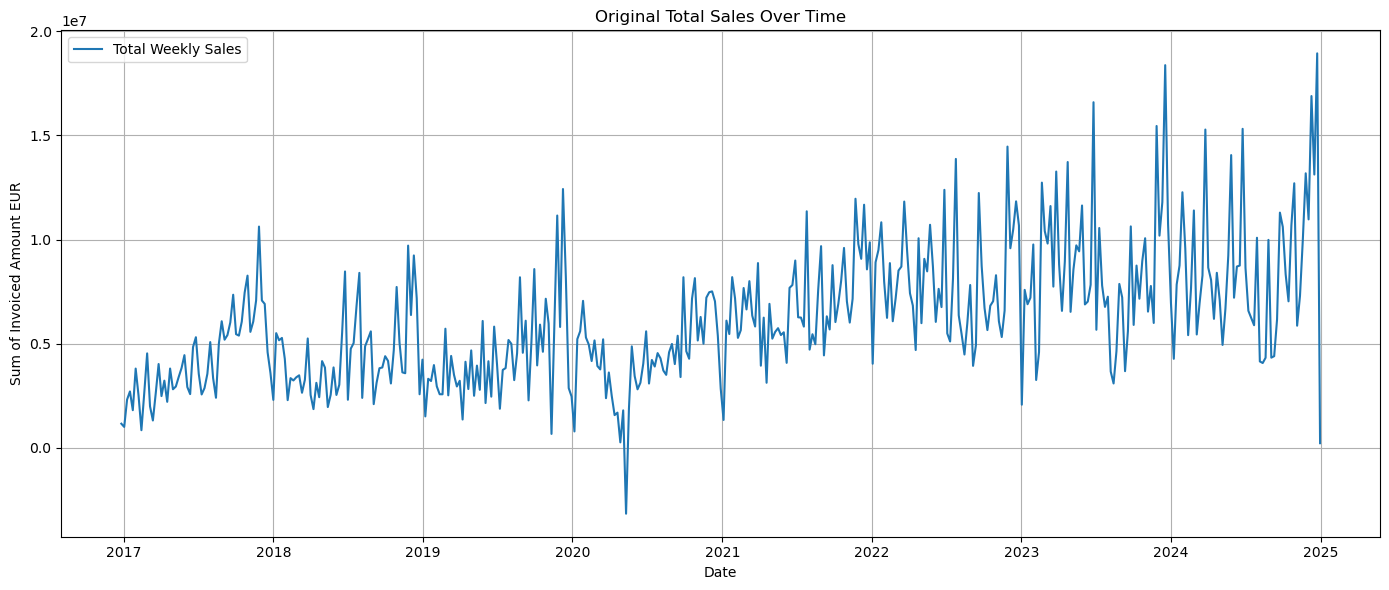

In [45]:
df = run_data_loading_pipeline()
plot_original_sales(df, target_col='Sum of Invoiced Amount EUR', date_col='date')



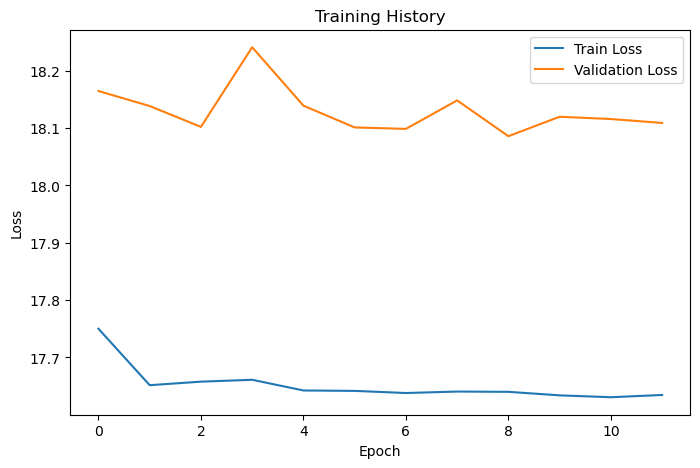

In [24]:
# Now you have train_gen available!
def plot_training_history(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
plot_training_history(history)


In [20]:
from keras_tuner import RandomSearch

input_window = 8
target_col = 'Sum of Invoiced Amount EUR'
exclude_cols = ['date', target_col]
num_features = processed_df.drop(columns=exclude_cols).shape[1]

input_shape = (input_window, num_features)

tuner = RandomSearch(
    hypermodel=lambda hp: build_model(hp, input_shape=input_shape),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_sales'
)




tuner.search(train_gen, validation_data=val_gen, epochs=10)
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from tuner_dir\lstm_sales\tuner0.json



C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print each best hyperparameter
print("\n🏆 Best Hyperparameters Found:")
for hp_name in best_hyperparameters.values.keys():
    print(f"{hp_name}: {best_hyperparameters.get(hp_name)}")



🏆 Best Hyperparameters Found:
lstm_units: 32
dropout: 0.2
lstm_units_2: 128
dropout_2: 0.1
dense_units: 32
learning_rate: 0.0005288480653096841


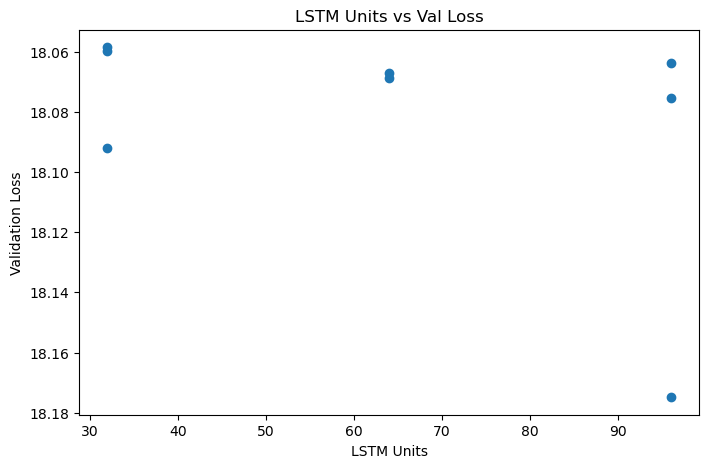

In [25]:
import matplotlib.pyplot as plt

# Extract all trials
trials = tuner.oracle.get_best_trials(num_trials=10)

val_losses = [trial.score for trial in trials]
lstm_units = [trial.hyperparameters.get('lstm_units') for trial in trials]

plt.figure(figsize=(8,5))
plt.scatter(lstm_units, val_losses)
plt.xlabel('LSTM Units')
plt.ylabel('Validation Loss')
plt.title('LSTM Units vs Val Loss')
plt.gca().invert_yaxis()
plt.show()


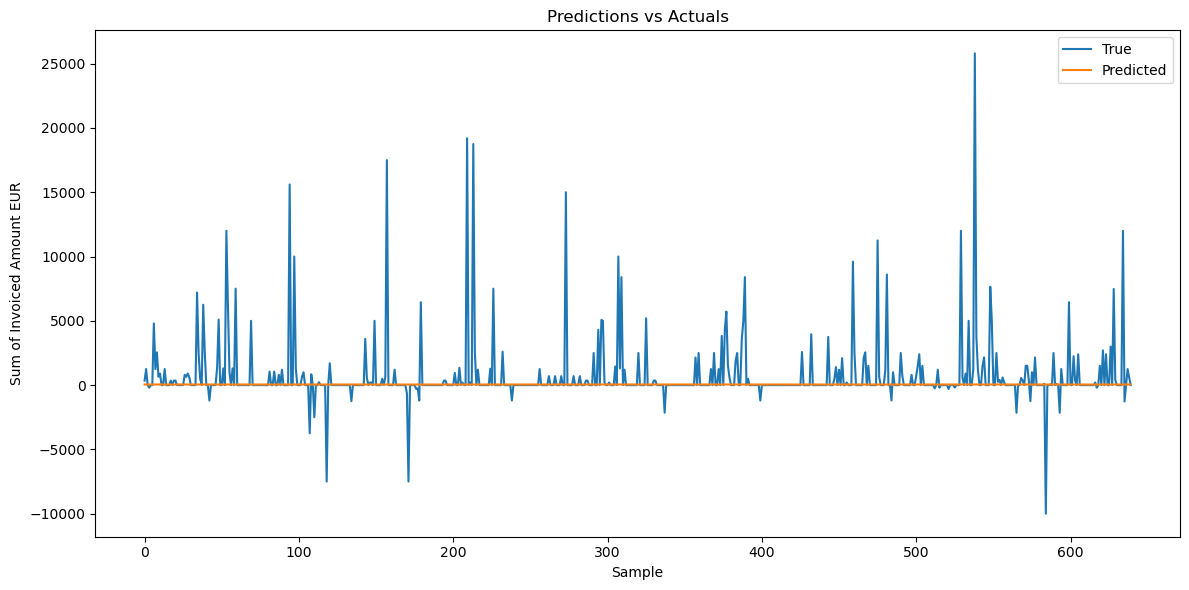


📊 Error Metrics:
RMSE: 2664.38
MAE: 902.44
MAPE: 323404365092.27%


In [23]:
# Evaluate best model on validation generator
evaluate_model(best_model, val_gen, n_batches=10)
